In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

In [2]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
style_data_path = '../Data/style_factors'
cluster_path = '../Outputs/country_clusters'

In [3]:
start_date = '2003-10-01'

## Load Data

### Read country sovereign bond index data

In [4]:
ticker_all = pd.read_csv(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_summary.csv'), skipinitialspace=True)

In [5]:
# optional: can apply filter to exclude some countries; this dictionary will be used to loop for regression
# ticker = ticker_all.loc[(ticker_all['Number of Issues'] > 5) & (ticker_all['Sum of Market Value (mm, USD)'] > 10000), :].copy()
ticker = ticker_all.copy()

In [6]:
ticker['Country'] = ticker['Full Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))

In [7]:
ticker['Index Full Name'] = ticker['Index BBG Ticker'] + ' Index'

In [8]:
ticker[['Index Full Name', 'Country']].head()

,Index Full Name,Country
0,GDID Index,Indonesia
1,GDTR Index,Turkey
2,GDMX Index,Mexico
3,GDEG Index,Egypt
4,GDPH Index,Philippines


In [9]:
ticker['Country'].unique()

array(['Indonesia', 'Turkey', 'Mexico', 'Egypt', 'Philippines', 'Bahrain',
       'Brazil', 'Colombia', 'Dominican Republic', 'Panama', 'Qatar',
       'South Africa', 'China', 'Israel', 'Ghana', 'Peru', 'Russia',
       'Sri Lanka', 'Chile', 'El Salvador', 'Ukraine', 'Nigeria',
       'Paraguay', 'South Korea', 'Uruguay', 'Guatemala', 'Romania',
       'Argentina', 'Costa Rica', 'Angola', 'Belarus', 'Jamaica',
       'Jordan', 'Kenya', 'Morocco', 'Pakistan', 'Bahamas', 'Hungary',
       'Kazakhstan', 'Malaysia', 'Mongolia', 'Poland', 'Azerbaijan',
       'Ecuador', 'Gabon', 'Honduras', 'Ivory Coast', 'Senegal',
       'Trinidad & Tobago', 'Zambia', 'Armenia', 'Croatia', 'Iraq',
       'Slovenia', 'Algeria', 'Aruba', 'Barbados', 'Belize', 'Greece',
       'Lithuania', 'Namibia', 'Rwanda', 'Serbia', 'Slovakia', 'Thailand',
       'Tunisia', 'Vietnam', 'Bulgaria', 'Fiji', 'Georgia', 'Iceland',
       'Latvia', 'Lebanon', 'Mozambique', 'Spain', 'Venezuela', 'Bolivia'],
      dtype=object)

In [10]:
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [11]:
bnd_idx_price = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

In [12]:
bnd_idx_price.drop(index=[0, 1], inplace=True)

In [13]:
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [14]:
bnd_idx_price.set_index('Date', inplace=True)

In [15]:
bnd_idx_price = bnd_idx_price.astype('float')

In [16]:
bnd_idx_price_monthly = bnd_idx_price.resample('M').last()

In [17]:
bnd_idx_price_monthly.replace(0, np.nan, inplace=True)

### Read Macro Factors Data

In [18]:
credit = pd.read_csv(os.path.join(macro_data_path, 'LF98TRUU_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['credit'])
currency = pd.read_csv(os.path.join(macro_data_path, 'MXEF0CX0_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['currency'])
equity = pd.read_csv(os.path.join(macro_data_path, 'WHANWIHD_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['equity'])

In [19]:
rates = pd.read_csv(os.path.join(macro_data_path, 'JPM_GBIEM.csv'), skiprows=7, header=None, index_col=0, names=['rates_last', 'rates_mid'])
rates.index = pd.to_datetime(rates.index)
rates = rates.sort_index()
rates = rates[['rates_last']]
rates.columns = ['rates']

In [20]:
macro_factors = credit.join(currency, how='inner').join(equity, how='inner').join(rates, how='inner')

In [21]:
macro_factors_monthly = macro_factors.resample('M').last()

In [22]:
macro_factors_monthly = macro_factors_monthly.astype('float')

### Read 3-Months LIBOR data

In [23]:
libor = pd.read_csv('../Data/others/USD3MTD156N.csv', index_col=0)
libor.columns = ['3M_libor']
libor['3M_libor'] = libor['3M_libor'].replace(['.'], np.nan)
libor.fillna(method='ffill')
libor = libor.apply(pd.to_numeric)
libor.index = pd.to_datetime(libor.index)

libor_monthly = libor.resample('M').first() / 1200 # convert annual data in % to a monthly return
libor_monthly = libor_monthly.shift(1).dropna() # using first data of the month and shift by a period, to match bond index return's date convention - end of month date represents return earned over that month

## Regression

In [24]:
bnd_index_ret = np.log(bnd_idx_price_monthly).diff()

In [25]:
bnd_index_ret.describe()

,GDAM Index,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,...,GDTH Index,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index
count,81.000000,101.000000,29.000000,99.000000,82.000000,168.000000,252.000000,211.000000,247.000000,252.000000,...,252.000000,225.000000,252.000000,193.000000,250.000000,252.000000,252.000000,193.000000,252.000000,99.000000
mean,0.006047,0.006631,-0.030350,0.004066,0.005400,0.003300,0.004364,0.000498,-0.028352,0.008063,...,0.002174,0.002953,0.007207,0.005278,0.009189,0.007198,0.005348,0.005765,0.006130,-0.000636
std,0.025372,0.105290,0.099993,0.015719,0.026430,0.034696,0.019377,0.004146,0.375968,0.042023,...,0.006958,0.012721,0.036664,0.022922,0.063254,0.057038,0.068971,0.030727,0.026784,0.080635
min,-0.135726,-0.893634,-0.338934,-0.069766,-0.132276,-0.165833,-0.147381,-0.028790,-1.386294,-0.210894,...,-0.026065,-0.072523,-0.180034,-0.184918,-0.479180,-0.381083,-0.552361,-0.281614,-0.191556,-0.457734
25%,-0.000509,-0.009947,-0.046797,0.000253,-0.006614,-0.004802,0.000000,0.000000,-0.223144,-0.008954,...,0.000000,0.000000,-0.009614,-0.000784,-0.008629,-0.008027,-0.013282,-0.001286,-0.006053,-0.031190
50%,0.007061,0.007067,-0.004017,0.004497,0.006777,0.000000,0.000000,0.000000,0.000000,0.011402,...,0.000000,0.000000,0.009581,0.006011,0.009573,0.008662,0.005048,0.007093,0.007877,-0.000797
75%,0.014938,0.024001,0.026629,0.007867,0.020004,0.012359,0.010756,0.000000,0.108293,0.025192,...,0.000511,0.006020,0.025770,0.014888,0.030000,0.031095,0.035912,0.017246,0.019398,0.028655
max,0.076157,0.337432,0.129239,0.071567,0.055869,0.170942,0.068749,0.022393,1.860752,0.233548,...,0.035111,0.062714,0.132061,0.084104,0.326299,0.297292,0.223687,0.099489,0.100748,0.327798


In [26]:
bnd_index_ret.replace(0, np.nan, inplace=True)

In [27]:
bnd_index_excess_ret = bnd_index_ret.subtract(libor_monthly['3M_libor'], axis=0).dropna(axis=0, how='all')

In [28]:
macro_factors_ret = np.log(macro_factors_monthly).diff().dropna()

In [29]:
macro_factors_ret.describe()

,credit,currency,equity,rates
count,191.000000,191.000000,191.000000,191.000000
mean,0.005827,0.002256,0.006560,0.003693
std,0.027960,0.019484,0.040996,0.012621
min,-0.173244,-0.078636,-0.171625,-0.039949
25%,-0.003483,-0.006882,-0.012876,-0.003229
50%,0.007352,0.003989,0.013603,0.005135
75%,0.016999,0.013584,0.030295,0.010941
max,0.114263,0.050544,0.114004,0.066541


In [30]:
def display_single_factor_performance(df, frequency):
    
    if frequency == 'M':
        df_mean = df.mean() * 12
        df_mean.name = 'Avg Return'
        df_vol = df.std() * np.sqrt(12)
        df_vol.name = 'Volatility'
        df_sr = df_mean / df_vol
        df_sr.name = 'Sharpe Ratio'
        
    df_result = df_mean.to_frame().join(df_vol).join(df_sr)
    # df_result.columns = ['Avg return', 'Volatility', 'Sharpe ratio']
    
    return df_result.round(3)

In [31]:
macro_performance = display_single_factor_performance(macro_factors_ret * 100, frequency='M')

In [32]:
macro_performance

,Avg Return,Volatility,Sharpe Ratio
credit,6.992,9.686,0.722
currency,2.707,6.750,0.401
equity,7.871,14.201,0.554
rates,4.432,4.372,1.014


In [33]:
results_df = pd.DataFrame()
results_dict = {} 

cols = ['const'] + macro_factors_ret.columns.tolist()
beta_cols = [x + '_beta' for x in cols]
tval_cols = [x + '_tval' for x in cols]

for bnd_index in bnd_index_excess_ret:
    
    country = ticker_dict[bnd_index]
    temp = bnd_index_excess_ret[bnd_index].dropna().to_frame().join(macro_factors_ret, how='inner')
    
    if temp.shape[0] > 30:

        y = temp.iloc[:, 0]
        X = temp.iloc[:, 1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()

        betas = results.params
        tvalues = results.tvalues
        rsq_adj = results.rsquared_adj
        f_pvalue = results.f_pvalue
        start_date = y.index.min().strftime('%Y%m')
        temp_results_df = pd.DataFrame(data=np.r_[betas, tvalues, rsq_adj, f_pvalue], 
                                       index=beta_cols + tval_cols + ['rsq_adj', 'f_pvalue']).T
        temp_results_df['country'] = country
        temp_results_df['start_date'] = start_date
        results_df = results_df.append(temp_results_df)
    
        results_dict[country] = results


In [34]:
results_df.describe()

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01
mean,-0.002390,0.751348,0.106040,-0.070305,0.559986,-0.372298,4.670096,0.019016,-0.773608,3.980593,0.423721,1.465004e-02
std,0.008071,0.806349,0.567295,0.190735,0.553070,1.295290,2.764371,1.439763,1.137473,3.444024,0.192534,7.975603e-02
min,-0.057076,-0.273499,-0.418816,-1.346559,-1.598084,-2.738879,-1.004248,-3.662358,-3.699185,-0.839482,-0.028561,1.721245e-47
25%,-0.003041,0.273274,-0.130448,-0.099070,0.254424,-1.192815,2.151888,-1.043907,-1.500113,0.927711,0.269731,1.885005e-28
50%,-0.000790,0.543780,-0.024736,-0.055490,0.565073,-0.447948,5.333330,-0.207836,-0.701890,3.455733,0.471820,5.495120e-18
75%,0.000399,0.954905,0.181010,-0.006013,0.912735,0.259847,6.558800,0.914314,-0.091505,6.292737,0.569895,5.809884e-10
max,0.010109,4.676858,3.977731,0.184428,1.800138,3.250745,10.186300,3.753299,1.903005,11.790931,0.693218,6.138402e-01


## Regression Results by Cluster

In [35]:
bond_idx_clusters = pd.read_pickle(os.path.join(cluster_path, 'clusters_bond_idx_ret_full.pkl'))
bond_idx_clusters.head()

,Countries,cluster_label
0,Bulgaria,0
1,Bolivia,0
2,Ukraine,0
3,Venezuela,0
4,El Salvador,1


In [36]:
set(bond_idx_clusters['Countries']) - set(results_df['country'])

set()

In [37]:
set(results_df['country']) - set(bond_idx_clusters['Countries'])

{'Angola',
 'Armenia',
 'Aruba',
 'Azerbaijan',
 'Bahamas',
 'Barbados',
 'Belarus',
 'Belize',
 'Ecuador',
 'Fiji',
 'Gabon',
 'Georgia',
 'Ghana',
 'Honduras',
 'Iceland',
 'Iraq',
 'Kenya',
 'Latvia',
 'Lithuania',
 'Mongolia',
 'Namibia',
 'Pakistan',
 'Paraguay',
 'Romania',
 'Rwanda',
 'Senegal',
 'Serbia',
 'Slovenia',
 'Spain',
 'Sri Lanka',
 'Trinidad & Tobago',
 'Tunisia',
 'Vietnam',
 'Zambia'}

In [38]:
results_with_cluster = results_df.merge(bond_idx_clusters, left_on='country', right_on='Countries')

In [39]:
beta_reformatted = results_with_cluster.set_index('cluster_label')[beta_cols].stack().to_frame().reset_index()
beta_reformatted.columns = ['cluster', 'beta', 'value']

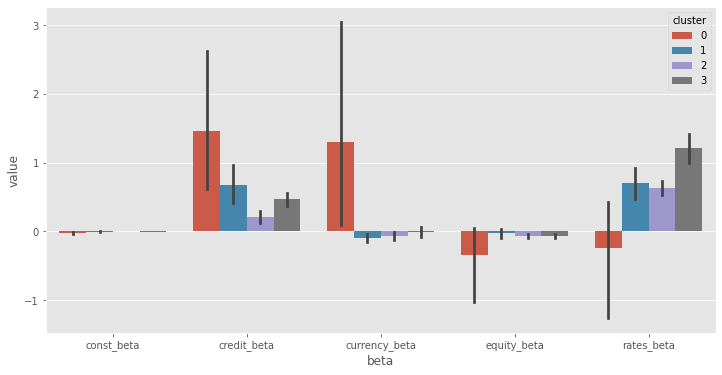

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='beta', y='value', data=beta_reformatted, hue='cluster')

In [41]:
tval_reformatted = results_with_cluster.set_index('cluster_label')[tval_cols].stack().to_frame().reset_index()
tval_reformatted.columns = ['cluster', 'tval', 'value']

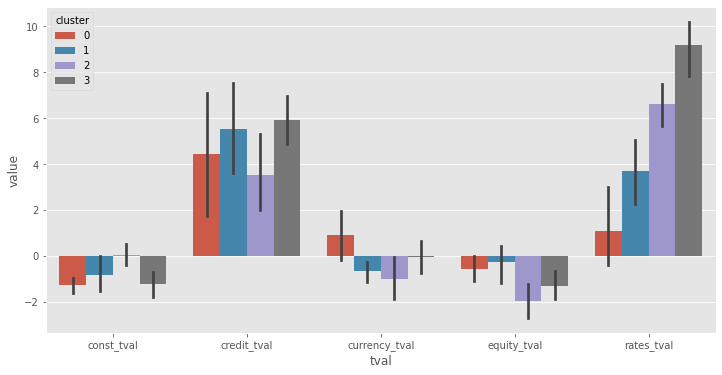

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='tval', y='value', data=tval_reformatted, hue='cluster')

In [43]:
beta_df = results_with_cluster.set_index('country')[beta_cols].T

In [44]:
tval_df = results_with_cluster.set_index('country')[tval_cols].T

In [45]:
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(16,3))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

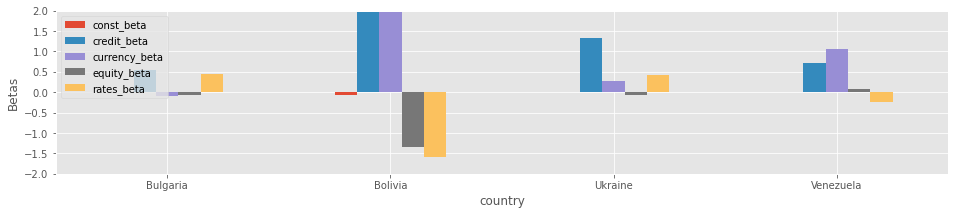

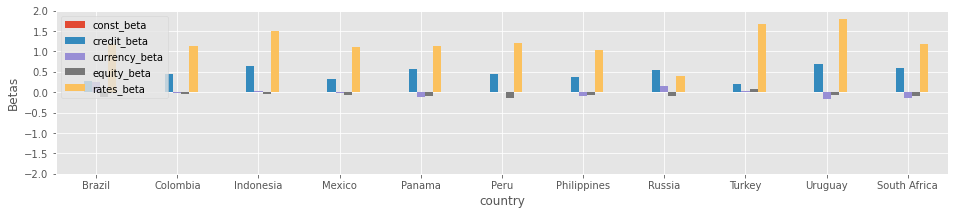

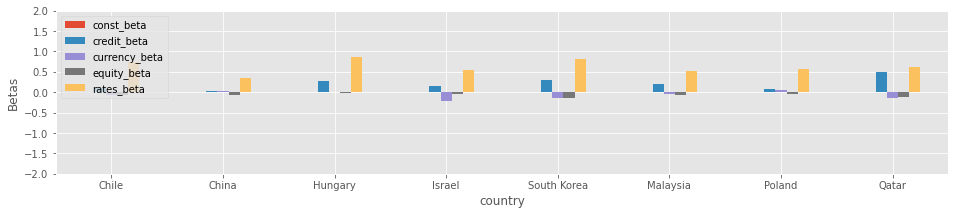

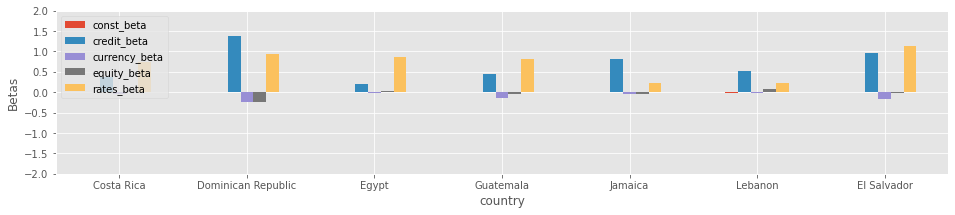

In [46]:
plot_multiple_clusters(results_with_cluster, beta_df, 2, 'Betas')

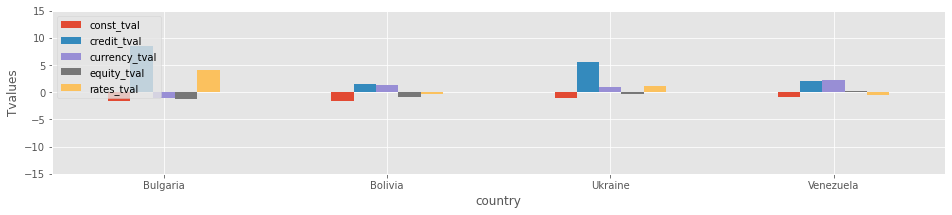

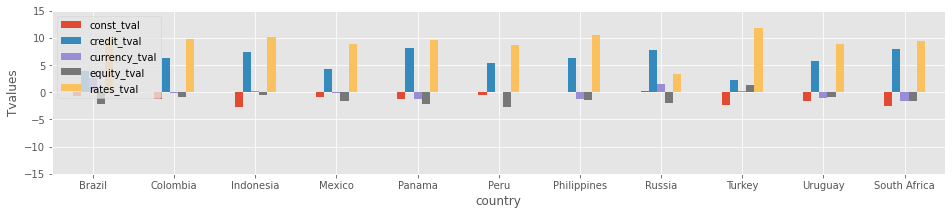

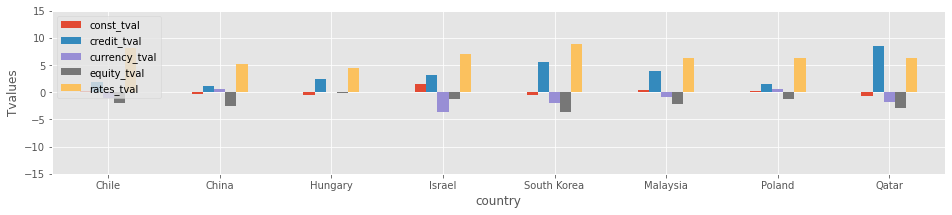

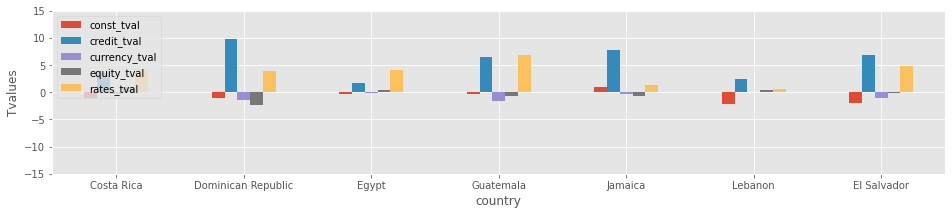

In [47]:
plot_multiple_clusters(results_with_cluster, tval_df, 15, 'Tvalues')

## Construct Style Factors

### Load index characteristics data

In [48]:
# read oas over gov data for all sov bond indices
oas1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats1.csv'), header=1, parse_dates=[0], nrows=7574, skipinitialspace=True)
oas1.dropna(axis=1, how="all", inplace=True) # delete empty column

oas2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats2.csv'), header=1, parse_dates=[0], nrows=7552, skipinitialspace=True)
oas2.dropna(axis=1, how="all", inplace=True)

oas3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats3.csv'), header=1, parse_dates=[0], nrows=6764, skipinitialspace=True)
oas3.dropna(axis=1, how="all", inplace=True)

oas4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats4.csv'), header=1, parse_dates=[0], nrows=6912, skipinitialspace=True)
oas4.dropna(axis=1, how="all", inplace=True)

oas = oas1[oas1['Date'] > start_date].merge(oas2, on='Date').merge(oas3, on='Date').merge(oas4, on='Date')
oas_monthly = oas.set_index('Date').resample('M').last()
oas_monthly.columns = oas_monthly.columns + ' Index'

In [49]:
# read foreign currency long term bond Moody's rating data
rating = pd.read_csv(os.path.join(style_data_path, 'sov_bond_rating.csv'), parse_dates=[2])
rating_unstacked = rating.set_index(['action_date', 'country']).unstack()['rating']
rating_daily = rating_unstacked.resample('D').ffill()
rating_daily = rating_daily.fillna(method='ffill')
rating_monthly = rating_daily[rating_daily.index > start_date].resample('M').last()

In [50]:
rating_monthly = rating_monthly.iloc[:-1, :] # drop 2020-Feb data to align with index data 

In [51]:
# read sovereign bond index full market value data
mv1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value1.csv'), header=1, parse_dates=[0], nrows=350, skipinitialspace=True)
mv1.dropna(axis=1, how="all", inplace=True) # delete empty column

mv2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value2.csv'), header=1, parse_dates=[0], nrows=349, skipinitialspace=True)
mv2.dropna(axis=1, how="all", inplace=True)

mv3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value3.csv'), header=1, parse_dates=[0], nrows=316, skipinitialspace=True)
mv3.dropna(axis=1, how="all", inplace=True)

mv4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value4.csv'), header=1, parse_dates=[0], nrows=350, skipinitialspace=True)
mv4.dropna(axis=1, how="all", inplace=True)

mv = mv1[mv1['Date'] > start_date].merge(mv2, on='Date').merge(mv3, on='Date').merge(mv4, on='Date')
mv_monthly = mv.set_index('Date').resample('M').last()
mv_monthly.columns = mv_monthly.columns + ' Index'

In [52]:
# read weighted average maturity data
maturity1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value1.csv'), skiprows=709, header=0, parse_dates=[0], nrows=350, skipinitialspace=True)
maturity1.dropna(axis=1, how="all", inplace=True)

maturity2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value2.csv'), skiprows=707, header=0, parse_dates=[0], nrows=349, skipinitialspace=True)
maturity2.dropna(axis=1, how="all", inplace=True)

maturity3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value3.csv'), skiprows=641, header=0, parse_dates=[0], nrows=316, skipinitialspace=True)
maturity3.dropna(axis=1, how="all", inplace=True)

maturity4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value4.csv'), skiprows=709, header=0, parse_dates=[0], nrows=350, skipinitialspace=True)
maturity4.dropna(axis=1, how="all", inplace=True)

maturity = maturity1[maturity1['Date'] > start_date].merge(maturity2, on='Date').merge(maturity3, on='Date').merge(maturity4, on='Date')
maturity_monthly = maturity.set_index('Date').resample('M').last()
maturity_monthly.columns = maturity_monthly.columns + ' Index'

In [53]:
maturity_monthly[ticker_dict].isna().sum().sort_values(ascending=False)

GDTH Index    110
GDDZ Index    110
GDGR Index    103
GDBG Index     85
GDMZ Index     83
             ... 
GDSN Index      0
GDTT Index      0
GDSV Index      0
GDHR Index      0
GDID Index      0
Length: 77, dtype: int64

### Filter for countries with cluster results

In [54]:
oas_monthly.columns = oas_monthly.columns.map(ticker_dict)
mv_monthly.columns = mv_monthly.columns.map(ticker_dict)
maturity_monthly.columns = maturity_monthly.columns.map(ticker_dict)

In [55]:
rating_monthly.rename(columns={'Korea':'South Korea'}, inplace=True)
rating_monthly_selected = rating_monthly[results_with_cluster['country']]

In [56]:
oas_monthly_selected = oas_monthly[results_with_cluster['country']]
mv_monthly_selected = mv_monthly[results_with_cluster['country']]
maturity_monthly_selected = maturity_monthly[results_with_cluster['country']]

### Construct value factor - cross sectional regression: OAS over Rating and Maturity

In [57]:
oas_monthly_selected.columns = pd.MultiIndex.from_product([['oas'], oas_monthly_selected.columns])
maturity_monthly_selected.columns = pd.MultiIndex.from_product([['maturity'], maturity_monthly_selected.columns])
rating_monthly_selected.columns = pd.MultiIndex.from_product([['rating'], rating_monthly_selected.columns])

In [58]:
value_data = oas_monthly_selected.join(maturity_monthly_selected).join(rating_monthly_selected)

In [59]:
value_data.columns = value_data.columns.sort_values()

In [60]:
value_data.replace(0, np.nan, inplace=True)

<AxesSubplot:xlabel='Date'>

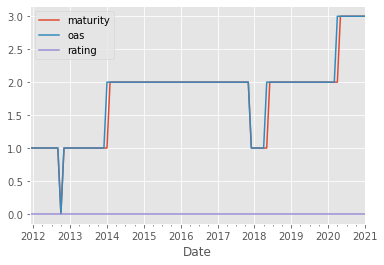

In [61]:
# check number of missing countries
value_data.T.groupby(level=0).apply(lambda x:x.isna().sum()).T.plot()

In [62]:
for index, row in value_data.iterrows():
    
    temp = row.unstack(level=0).dropna()
    if len(temp) > :
        y = temp['oas']
        X = temp[['maturity', 'rating']]
    
    

SyntaxError: invalid syntax (<ipython-input-62-1940683cacd5>, line 4)